## Import Packages

In [35]:
import boto3
import sagemaker
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Establish Session Connection with AWS Sagemaker and S3

In [36]:
session = boto3.session.Session()
region_name = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'

## Test Connection by Querying Glue Catalogue using Athena

In [37]:
# PyAthena imports
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

# Set S3 staging directory 
# This is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute("""
SELECT DISTINCT product_category from {0}.{1} 
ORDER BY product_category 
""".format(database_name, table_name))

### Save cursor as a pandas datatram

In [38]:
df_categories = as_pandas(cursor)
df_categories.head()

,product_category
0,Apparel
1,Automotive
2,Baby
3,Beauty
4,Books


## Let's answer some question and visualise the results

In [39]:
# Creating a function to display results as a bar chart
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

### Which product categories are the highest rated by average rating?

In [40]:
# Start with a SQL statement
statement = """
SELECT product_category, AVG(star_rating) as avg_star_rating
FROM {}.{}
GROUP BY product_category
ORDER BY avg_star_rating DESC
""".format(database_name, table_name)

In [41]:
#use cursor in Pyathena to execute query and return results
cursor.execute(statement)

df = as_pandas(cursor)

In [42]:
# Store number of categories
num_categories = df.shape[0]
print(num_categories)

# Store average star ratings
average_star_ratings = df

43


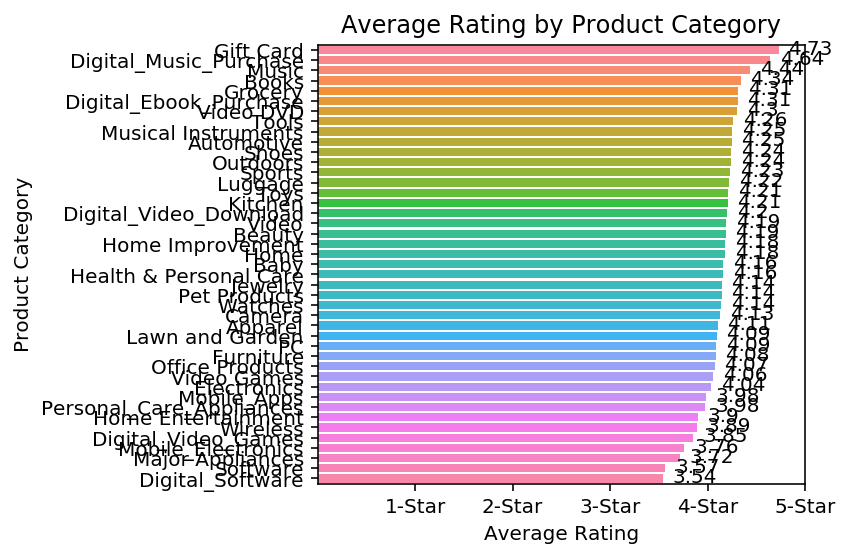

In [43]:
#Visualizing Average Score of each Product Category using a Bar Plot

# Create plot
barplot = sns.barplot(y='product_category', x='avg_star_rating', data = df, saturation=1)

if num_categories < 10:
    sns.set(rc={'figure.figsize':(10.0, 5.0)})
    
# Set title and x-axis ticks 
plt.title('Average Rating by Product Category')
plt.xticks([1, 2, 3, 4, 5], ['1-Star', '2-Star', '3-Star','4-Star','5-Star'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

### Which Product Categories Have the Most Reviews?

In [44]:
statement = """
SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM {}.{}
GROUP BY product_category 
ORDER BY count_star_rating DESC
""".format(database_name, table_name)

In [45]:
#use cursor in Pyathena to execute query and return results
cursor.execute(statement)

df = as_pandas(cursor)

In [46]:
# Store counts
count_ratings = df['count_star_rating']

# Store max ratings
max_ratings = df['count_star_rating'].max()
print(max_ratings)

19531329


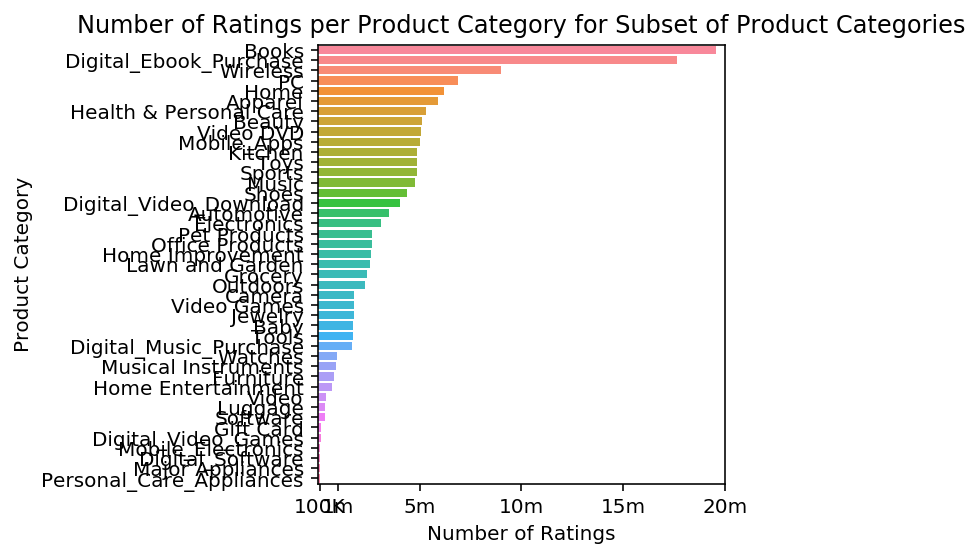

In [47]:
#Visualizing Number of Review of each Product Category using a Bar Plot
# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

if num_categories < 10:
    sns.set(rc={'figure.figsize':(10.0, 5.0)})

# Set title
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# Set x-axis ticks to match scale 
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '150K', '200K'])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

###  When did each product category become available in the Amazon catalog based on the date of the first review?

In [48]:
statement = """
SELECT product_category, MIN(review_date) AS first_review_date
FROM {}.{}
GROUP BY product_category
ORDER BY first_review_date 
""".format(database_name, table_name)

In [49]:
#use cursor in Pyathena to execute query and return results
cursor.execute(statement)

df = as_pandas(cursor)

In [50]:
# Convert date strings (e.g. 2014-10-18) to datetime
import datetime as datetime
dates = pd.to_datetime(df['first_review_date'])

In [51]:
# create some helper functions to plot a time-series function
# Convert date strings (e.g. 2014-10-18) to datetime
def modify_dataframe(df):
    """ Modify dataframe to include new columns """
    df['year'] = pd.to_datetime(df['first_review_date'], format='%Y-%m-%d').dt.year
    return df

def get_x_y(df):
    """ Get X and Y coordinates; return tuple """
    series = df['year'].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    return series.index, series.values

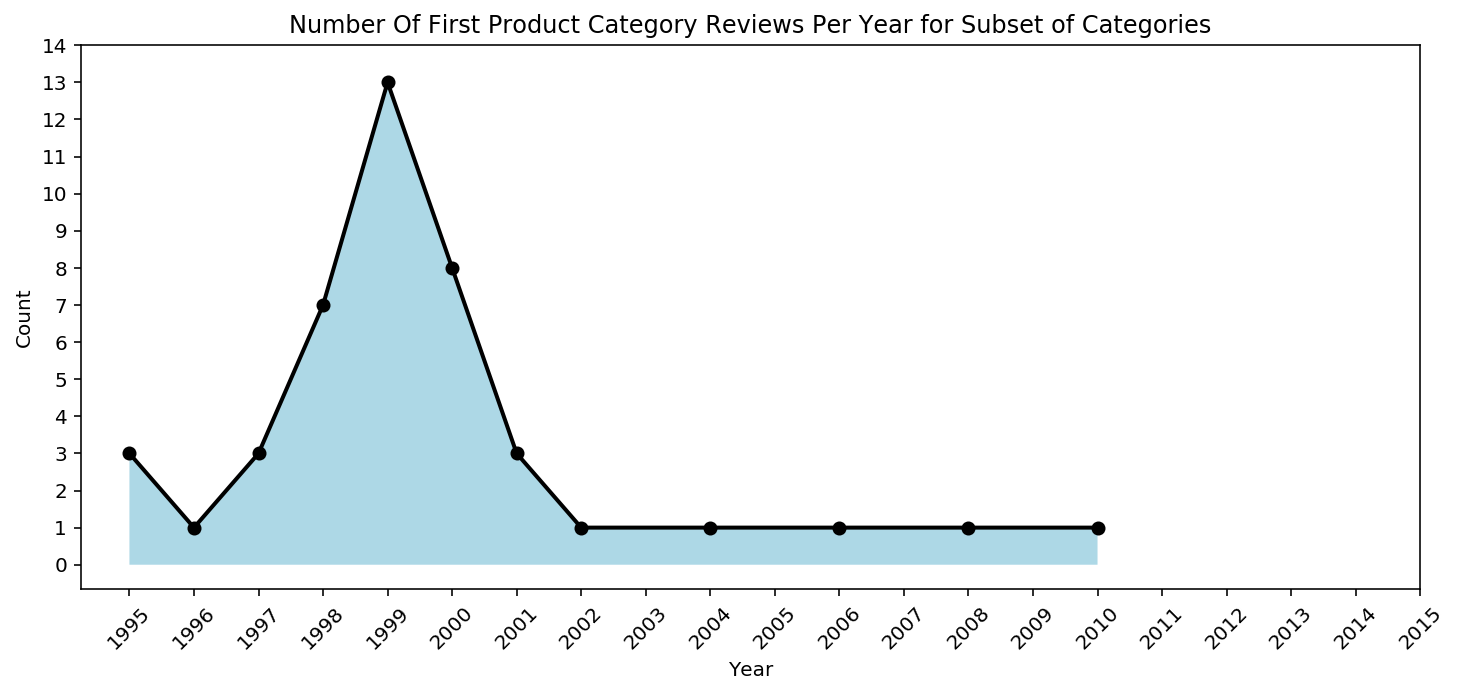

In [52]:
new_df = modify_dataframe(df)

X, Y = get_x_y(new_df)

fig = plt.figure(figsize=(12,5))
ax = plt.gca()

ax.set_title('Number Of First Product Category Reviews Per Year for Subset of Categories')
ax.set_xlabel('Year')
ax.set_ylabel('Count')

ax.plot(X, Y, color="black", linewidth=2, marker="o")
ax.fill_between(X, [0]*len(X), Y, facecolor='lightblue')

ax.locator_params(integer=True)

ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y)+2, 1))

plt.xticks(rotation=45)

# fig.savefig('first_reviews_per_year.png', dpi=300)
plt.show()

### What is the breakdown of ratings (1-5) per product category?

In [53]:
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name)

In [54]:
#use cursor in Pyathena to execute query and return results
cursor.execute(statement)

df = as_pandas(cursor)

In [55]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.groupby('product_category')
grouped_star = df.groupby('star_rating')

# Create sum of ratings per star rating
df_sum = df.groupby(['star_rating']).sum()

# Calculate total number of star ratings
total = df_sum['count_reviews'].sum()
print(total)

150962278


In [56]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i=0
    
for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings['star_rating']:
        count_reviews_per_star.append(ratings.at[i, 'count_reviews'])
        i=i+1;
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)

{'Apparel': [3320566, 1147237, 623471, 369601, 445458], 'Automotive': [2300757, 526665, 239886, 147767, 299867], 'Baby': [1070258, 287370, 149935, 100956, 144413], 'Beauty': [3254909, 741434, 398402, 264029, 456892], 'Books': [12874022, 3352504, 1452686, 808056, 1044061], 'Camera': [1062707, 336701, 141460, 90949, 170157], 'Digital_Ebook_Purchase': [10632313, 3983850, 1568686, 690426, 747140], 'Digital_Music_Purchase': [1345149, 207333, 62404, 25018, 48980], 'Digital_Software': [46410, 16693, 8308, 6890, 23783], 'Digital_Video_Download': [2446375, 767302, 350900, 198566, 294004], 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970], 'Electronics': [1781161, 536821, 238587, 179180, 358120], 'Furniture': [447716, 153666, 73563, 43848, 73320], 'Gift Card': [129709, 9859, 3156, 1569, 4793], 'Grocery': [1662261, 293389, 161495, 105265, 180048], 'Health & Personal Care': [3358258, 781760, 400428, 277981, 513022], 'Home': [3893005, 959228, 500416, 324062, 544848], 'Home Entertainment': [

In [57]:
# Sort distribution by highest average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:,0]
for index, value in average_star_ratings.iloc[:,0].items():
    sorted_distribution[value] = distribution[value]

In [58]:
# Build array per star across all categories
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_distribution.keys():
    stars = sorted_distribution.get(k)
    star5.append(stars[0])
    star4.append(stars[1])
    star3.append(stars[2])
    star2.append(stars[3])
    star1.append(stars[4])

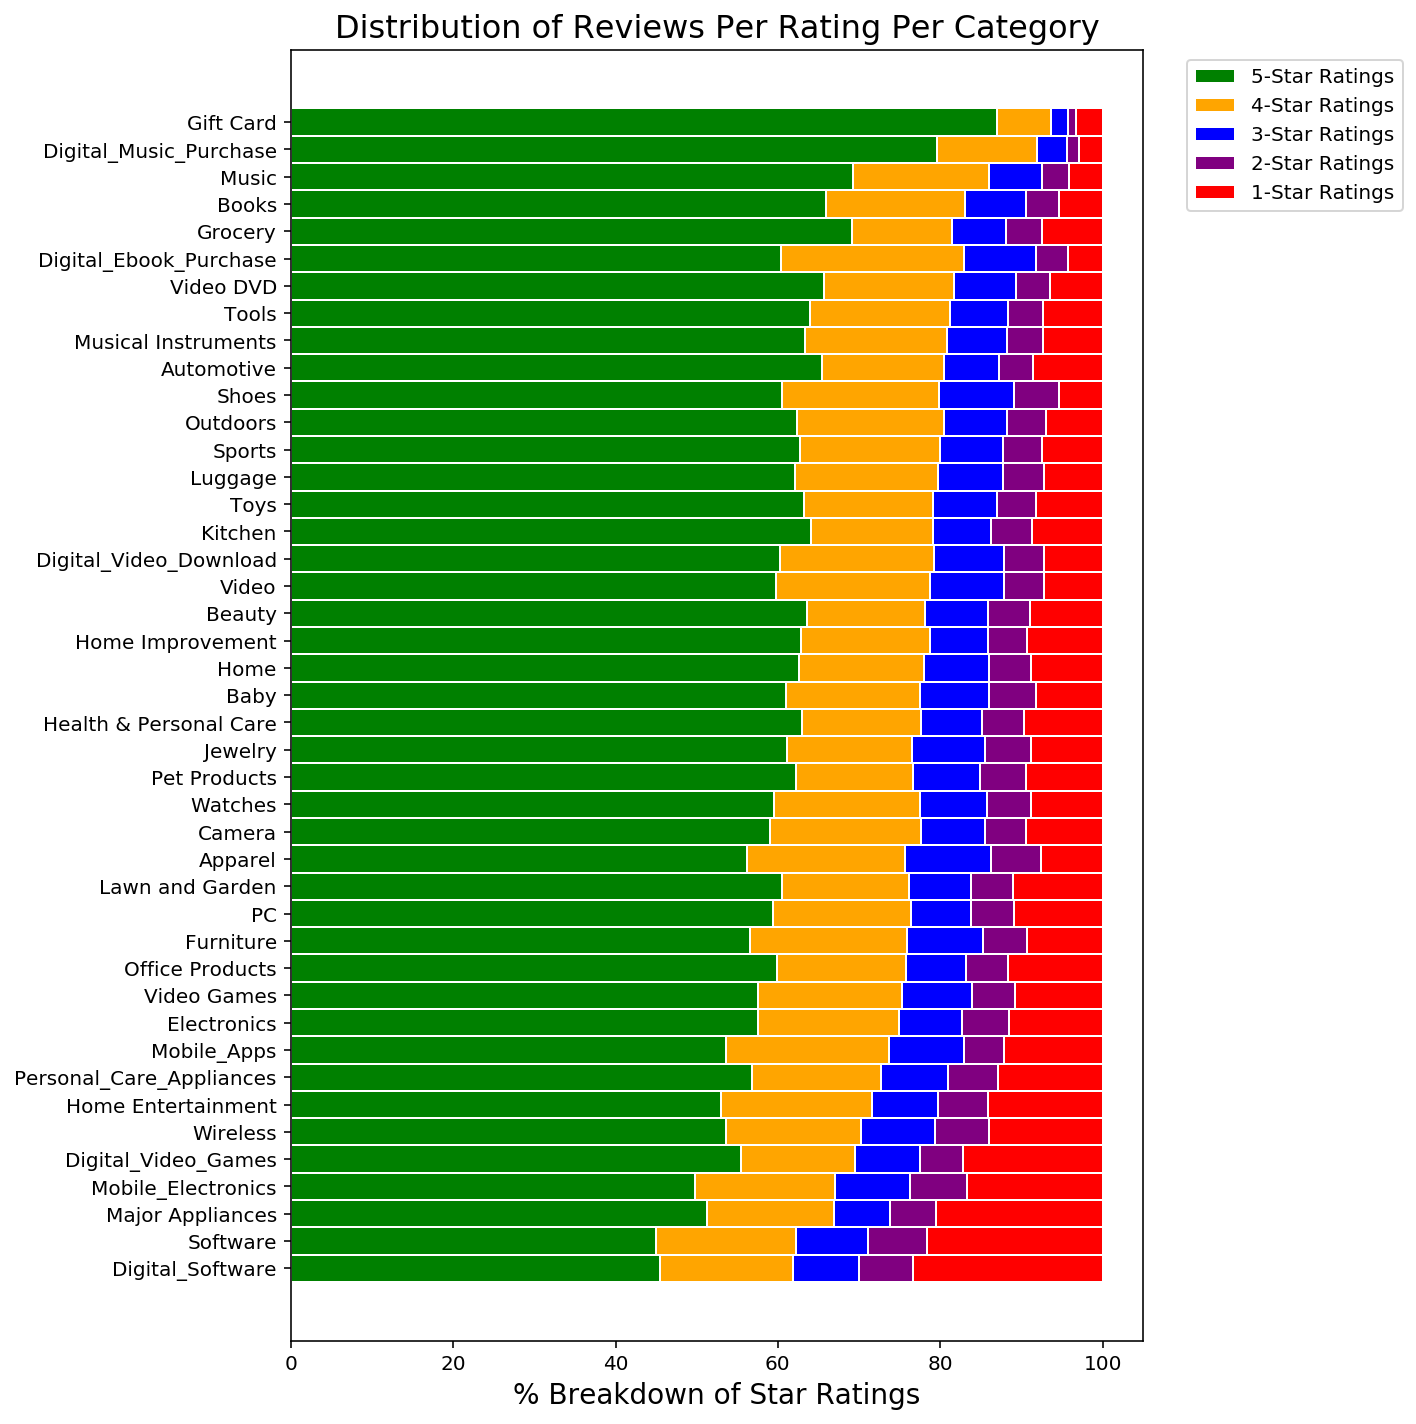

In [59]:
# Plot the distributions of star ratings per product category

categories = sorted_distribution.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ['red', 'purple','blue','orange','green']

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 1

# Plot bars
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_star4, left=proportion_star5, color=colors[3], edgecolor='white', height=barHeight, label='4-Star Ratings')
ax3 = plt.barh(r, proportion_star3, left=proportion_star5+proportion_star4, color=colors[2], edgecolor='white', height=barHeight, label='3-Star Ratings')
ax2 = plt.barh(r, proportion_star2, left=proportion_star5+proportion_star4+proportion_star3, color=colors[1], edgecolor='white', height=barHeight, label='2-Star Ratings')
ax1 = plt.barh(r, proportion_star1, left=proportion_star5+proportion_star4+proportion_star3+proportion_star2, color=colors[0], edgecolor='white', height=barHeight, label="1-Star Ratings")

plt.title("Distribution of Reviews Per Rating Per Category",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, categories, fontweight='regular')

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

# plt.savefig('proportion_star_per_category.png', dpi=300)
plt.show()